dataRot Results
STAT_e : 0
cannot calculate other descriptors



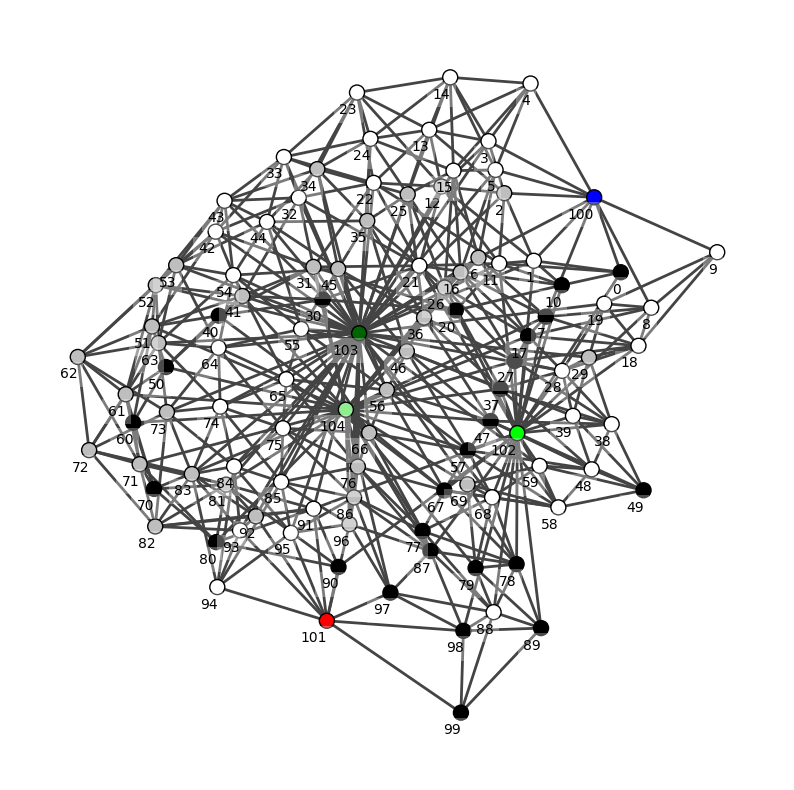

data_10_10 Results
STAT_e: 19



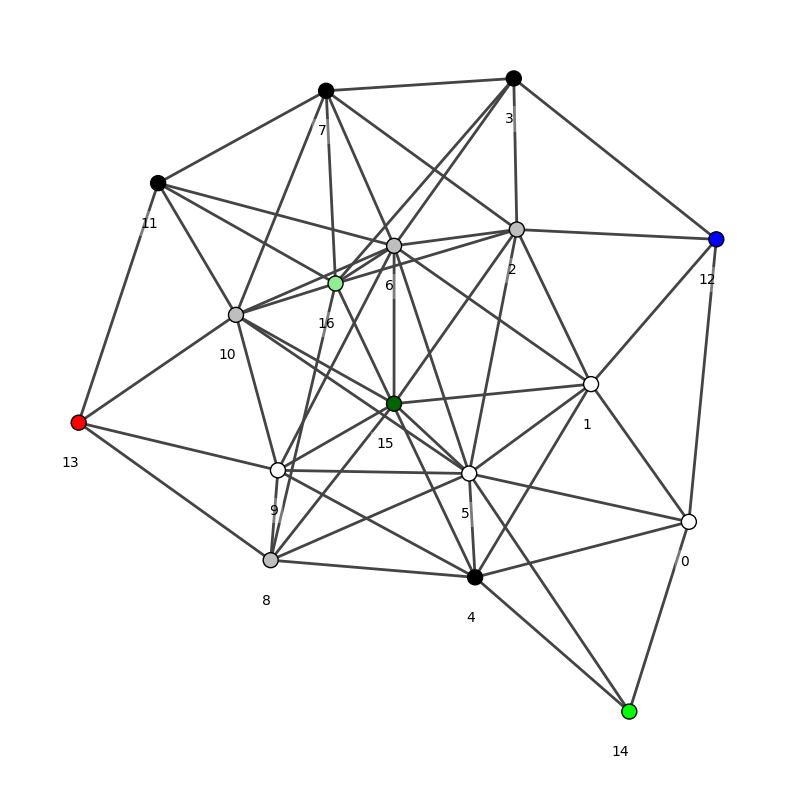

data_4_3 Results
STAT_e: 2

data_stripe Results
STAT_e : 0
cannot calculate other descriptors



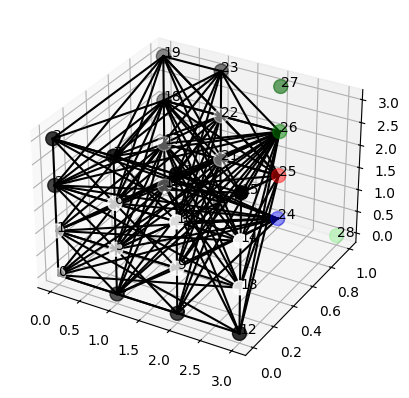

data_4_3_2 Results
STAT_e: 20



In [10]:
import sys
import os
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, "../src"))
sys.path.append(src_path)


from py_graspi import descriptors as ds
from py_graspi import graph as ig

import time
import matplotlib.pyplot as plt
import tracemalloc
import importlib

importlib.reload(ig)  # reload the module (apply modification)
importlib.reload(ds)  # reload the module (apply modification)


current_dir = os.getcwd()
data_path = f"../data/3phase/data/"
descriptors_path = f"../data/descriptors/"
result_path = f"./test_results/"
test_files = [os.path.splitext(file)[0] for file in os.listdir(data_path)]
epsilon=1e-5

times = []
mems = []
time_mem_stats = {}

for test_file in test_files:
    import time
    tracemalloc.start()
    graph_start = time.time()
    g_data = ig.generateGraph(data_path+test_file+".txt")    
    mem_graph = tracemalloc.get_traced_memory()
    graph_end = time.time()
    tracemalloc.stop()
    graph_mem = mem_graph[1]-mem_graph[0]  
    
    if g_data.black_green == 0:
        print(f"{test_file} Results")
        print("STAT_e : 0")
        print("cannot calculate other descriptors")
        print("")
        continue
    tracemalloc.start()
    desc_start = time.time()
    stats = ds.compute_descriptors(g_data, test_file+".txt", 1)
    mem_desc = tracemalloc.get_traced_memory()
    desc_end = time.time()
    tracemalloc.stop()
    descriptor_time = desc_end - desc_start
    descriptor_mem = mem_desc[1]-mem_desc[0]
    for idx, v in enumerate(g_data.graph.vs):
        color = v.attributes().get("color")
        if color is None:
            print(f"[DEBUG] Vertex {idx} has no 'color' attribute.")
        elif color == "":
            print(f"[DEBUG] Vertex {idx} has empty 'color' string.")

    ig.visualize(g_data.graph, g_data.is_2D)

    print(f"{test_file} Results")

    try:
        with open(descriptors_path + "descriptors." + test_file + ".log") as f:
            for line in f:
                stat = line.strip().split(" ")
                try:
                    # if stats.get(stat[0], -1) == int(stat[1]):
                    if abs(stats.get(stat[0], -1) - float(stat[1])) < epsilon:
                        print(f"{stat[0]} passed")
                    elif stats.get(stat[0], -1) != -1 and stats.get(stat[0], -1) != int(stat[1]):
                        print(f"{stat[0]} failed - {stats.get(stat[0])} is not the same as expected {stat[1]}")
                except ValueError:
                    if abs(stats.get(stat[0], -1) - float(stat[1])) < epsilon:
                        print(f"{stat[0]} passed")
                    elif stats.get(stat[0], -1) != -1 and stats.get(stat[0], -1) != float(stat[1]):
                        print(f"{stat[0]} failed - {stats.get(stat[0])} is not the same as expected {stat[1]}")

    except FileNotFoundError:
        # print(f"File not found: {descriptors_path + 'descriptors.' + test_file + '.log'}")
        for key in stats:
            if key == "STAT_e":
                print(f"{key}: {stats[key]}")
                print("")

    times.append(descriptor_time)
    mems.append(descriptor_mem)

    graph_time = graph_end-graph_start
    # print(f"Total time to calculate graph: {graph_time} second(s)")
    # print(f"Total time to calculate descriptors: {descriptor_time} second(s)")
    # print(f"Peak memory usage for graph generation: {graph_mem} bytes")
    # print(f"Peak memory usage for descriptor calculation: {descriptor_mem} bytes")
    # print(stats)
    # print("")
    time_mem_stats[test_file] = {"graph_time": graph_time, "descriptor_time": descriptor_time,  "graph_mem":graph_mem, "descriptor_mem": descriptor_mem}

